In [1]:
import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import cv2
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report

from tensorflow.keras.layers import concatenate
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.metrics import CategoricalAccuracy
from keras.regularizers import l2
from tensorflow.keras.applications.inception_v3 import InceptionV3

pd.set_option('display.max_columns', None)

In [2]:
train_df = pd.read_csv('data/twitter_data_train_multiclass.csv')
test_df = pd.read_csv('data/twitter_data_test_multiclass.csv')

In [3]:
scaler = MinMaxScaler() 
train_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']] = scaler.fit_transform(train_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']])
test_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']] = scaler.transform(test_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']])

## ANN
training a ANN with categorical and numerical attributes

In [4]:
to_drop = ['Unnamed: 0', 'screen_name', 'url', 'profile_image_url', 'description',
           'id', 'name', 'account_type', 'tweets_list', 'tweets_list_processed',
          'description_processed', 'protected', 'verified', 'account_type_multi', 
          'profile_use_background_image', 'profile_background_tile']

x_train, y_train = train_df.drop(to_drop, axis=1), train_df['account_type_multi']
x_test, y_test = test_df.drop(to_drop, axis=1), test_df['account_type_multi']

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)

In [114]:
start_time = time.time()

ann_model = Sequential()
ann_model.add(Dense(64, activation = 'relu', input_dim = 222))
ann_model.add(Dropout(.1))
ann_model.add(Dense(128, activation='relu'))
ann_model.add(Dense(6, activation='softmax'))

ann_model.summary()
# configure the model
ann_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 64)                14272     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 128)               8320      
                                                                 
 dense_44 (Dense)            (None, 6)                 774       
                                                                 
Total params: 23,366
Trainable params: 23,366
Non-trainable params: 0
_________________________________________________________________


In [115]:
start_time = time.time()
history = ann_model.fit(x_train, y_train, epochs=20, batch_size=50, validation_data=(x_val, y_val))
time_taken = time.time() - start_time
print("Total time taken for the program execution", time_taken) # seconds

score = ann_model.evaluate(x_train, y_train, verbose=0)
print(f'Train loss: {score[0]} / Train accuracy: {score[1]}')

score = ann_model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/20
161/161 [==============================] - 1s 2ms/step - loss: 0.7071 - accuracy: 0.7824 - val_loss: 0.2900 - val_accuracy: 0.9224
Epoch 2/20
161/161 [==============================] - 0s 1ms/step - loss: 0.2680 - accuracy: 0.9210 - val_loss: 0.1545 - val_accuracy: 0.9584
Epoch 3/20
161/161 [==============================] - 0s 1ms/step - loss: 0.1655 - accuracy: 0.9558 - val_loss: 0.1237 - val_accuracy: 0.9633
Epoch 4/20
161/161 [==============================] - 0s 1ms/step - loss: 0.1478 - accuracy: 0.9656 - val_loss: 0.1012 - val_accuracy: 0.9774
Epoch 5/20
161/161 [==============================] - 0s 1ms/step - loss: 0.1141 - accuracy: 0.9721 - val_loss: 0.1542 - val_accuracy: 0.9739
Epoch 6/20
161/161 [==============================] - 0s 1ms/step - loss: 0.0989 - accuracy: 0.9746 - val_loss: 0.1095 - val_accuracy: 0.9781
Epoch 7/20
161/161 [==============================] - 0s 1ms/step - loss: 0.1026 - accuracy: 0.9776 - val_loss: 0.0869 - val_accuracy: 0.9802
Epoch 

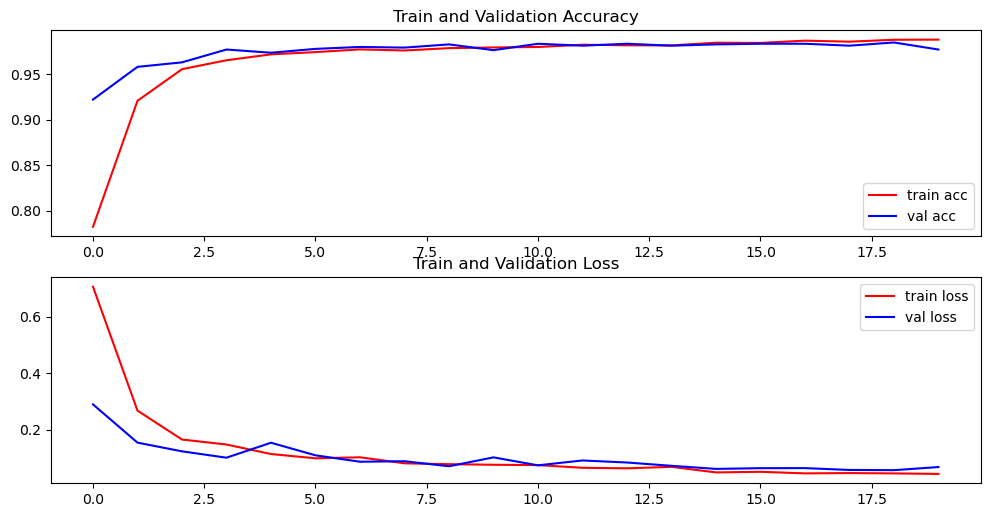

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6), dpi=100)
plt.subplot(2,1,1)
plt.plot(acc, 'r', label='train acc')
plt.plot(val_acc, 'b', label='val acc')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.subplot(2,1,2)
plt.plot(loss, 'r', label='train loss')
plt.plot(val_loss, 'b', label='val loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.show()

In [117]:
pred = ann_model.predict(x_test)
pred = np.argmax(pred,axis=1)
print(classification_report(y_test, pred, digits=5))

53/53 [==============================] - 0s 701us/step
              precision    recall  f1-score   support

           0    0.96359   0.96126   0.96242       413
           1    0.97655   0.99565   0.98601       460
           2    0.96364   0.91379   0.93805        58
           3    0.99545   0.98498   0.99019       666
           4    0.91071   0.96226   0.93578        53
           5    1.00000   0.94118   0.96970        17

    accuracy                        0.97840      1667
   macro avg    0.96832   0.95985   0.96369      1667
weighted avg    0.97859   0.97840   0.97840      1667



## CNN
training a CNN using user's profile photos

In [4]:
faces_base = "../new batch profile pics/"

In [5]:
# get all image pathnames from base
# list to store files
res = []
res2 = []

# Iterate directory
for path in os.listdir(faces_base):
    # check if current path is a file
    if os.path.isfile(os.path.join(faces_base, path)):
        res.append(faces_base + path)
        res2.append(path)

### Pre trained CNN: InceptionV3

In [6]:
train_img_dict2 = {}
test_img_dict2 = {}
train_img2 = []
test_img2 = []
for i in range(len(res)):
    pic = res[i]
    id_name = re.match(r"[^\/\\]+(?=\.png|\.jpg)", res2[i]).group(0)
    try:
        img = cv2.imread(pic)
        if img is None:
            print("none")
            continue
        img = cv2.resize(img, (75, 75))
        if int(id_name) in list(train_df['id']):
            train_img_dict2[int(id_name)] = img 
            train_img2.append(img)
        elif int(id_name) in list(test_df['id']):
            test_img_dict2[int(id_name)] = img
            test_img2.append(img)
        #img.close()
    except Exception as e:
        print(e)

none
none
none
none
none
none
none
none
none
none
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
none
none
none
none
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
none
none
libpng warning: iCCP: known incorrect sRGB profile
none
none
none
none
none


In [7]:
train_img_df2 = pd.DataFrame(train_img_dict2.items(), columns = ['id', 'img'])  
test_img_df2 = pd.DataFrame(test_img_dict2.items(), columns = ['id', 'img'])  
train_df_with_img2 = pd.merge(train_img_df2, train_df, on='id')
test_df_with_img2 = pd.merge(test_img_df2, test_df, on='id')

In [8]:
base_model = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(70, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)
model = Model(base_model.input, x)
# configure the model
model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

2022-11-13 21:36:07.743057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(np.array(train_img2) / 255.0, train_df_with_img2['account_type_multi'], test_size=0.15)

In [10]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
inc_history = model.fit(x_train2, y_train2, epochs=100, batch_size=20, validation_data=(x_val2, y_val2), callbacks = es_callback)

Epoch 1/100
401/401 [==============================] - 94s 194ms/step - loss: 1.2926 - accuracy: 0.4468 - val_loss: 1.1150 - val_accuracy: 0.5095
Epoch 2/100
401/401 [==============================] - 75s 187ms/step - loss: 1.1433 - accuracy: 0.5117 - val_loss: 1.0774 - val_accuracy: 0.5350
Epoch 3/100
401/401 [==============================] - 65s 163ms/step - loss: 1.0892 - accuracy: 0.5289 - val_loss: 1.0589 - val_accuracy: 0.5399
Epoch 4/100
401/401 [==============================] - 60s 151ms/step - loss: 1.0404 - accuracy: 0.5490 - val_loss: 1.0397 - val_accuracy: 0.5463
Epoch 5/100
401/401 [==============================] - 45s 112ms/step - loss: 0.9998 - accuracy: 0.5728 - val_loss: 1.0414 - val_accuracy: 0.5449
Epoch 6/100
401/401 [==============================] - 33s 82ms/step - loss: 0.9652 - accuracy: 0.5929 - val_loss: 1.0578 - val_accuracy: 0.5456
Epoch 7/100
401/401 [==============================] - 34s 84ms/step - loss: 0.9355 - accuracy: 0.6124 - val_loss: 1.0521 - v

In [11]:
score = model.evaluate(x_train2, y_train2, verbose=0)
print(f'Train loss: {score[0]} / Train accuracy: {score[1]}')

Train loss: 0.12508568167686462 / Train accuracy: 0.9568309187889099


In [14]:
score = model.evaluate(np.array(test_img2) / 255.0, test_df_with_img2['account_type_multi'], verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 2.0648679733276367 / Test accuracy: 0.5932611227035522


In [25]:
pred = model.predict(np.array(test_img2) / 255.0)
pred = np.argmax(pred,axis=1)

52/52 [==============================] - 6s 117ms/step


In [29]:
print(classification_report(test_df_with_img2['account_type_multi'], pred, digits=5))

              precision    recall  f1-score   support

           0    0.44811   0.46117   0.45455       412
           1    0.50713   0.54130   0.52366       460
           2    0.27273   0.05357   0.08955        56
           3    0.73521   0.78378   0.75872       666
           4    0.60000   0.11765   0.19672        51
           5    1.00000   0.94118   0.96970        17

    accuracy                        0.59326      1662
   macro avg    0.59386   0.48311   0.49882      1662
weighted avg    0.58389   0.59326   0.58062      1662



### Self-train CNN

In [44]:
train_img_dict = {}
test_img_dict = {}
train_img = []
test_img = []
for i in range(len(res)):
    pic = res[i]
    id_name = re.match(r"[^\/\\]+(?=\.png|\.jpg)", res2[i]).group(0)
    try:
        img = cv2.imread(pic)
        if img is None:
            print("none")
            continue
        if int(id_name) in list(train_df['id']):
            train_img_dict[int(id_name)] = img 
            train_img.append(img)
        elif int(id_name) in list(test_df['id']):
            test_img_dict[int(id_name)] = img
            test_img.append(img)
        #img.close()
    except Exception as e:
        print(e)

none
none
none
none
none
none
none
none
none
none
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
none
none
none
none
libpng warning: iCCP: profile 'icc': 'RGB ': RGB color space not permitted on grayscale PNG
none
none
libpng warning: iCCP: known incorrect sRGB profile
none
none
none
none
none


In [348]:
len(train_img_dict)

9430

In [45]:
train_img_df = pd.DataFrame(train_img_dict.items(), columns = ['id', 'img'])  
test_img_df = pd.DataFrame(test_img_dict.items(), columns = ['id', 'img'])  
train_df_with_img = pd.merge(train_img_df, train_df, on='id')
test_df_with_img = pd.merge(test_img_df, test_df, on='id')

In [383]:
kernel_size = (3, 3)
stride_size = (1, 1)
filters = [4, 8, 16]

cnn_model = Sequential()
cnn_model.add(Input(shape=(48, 48, 3)))
for f in filters:
    cnn_model.add(Conv2D(f, kernel_size, strides=stride_size, activation='relu'))
    cnn_model.add(Dropout(0.1))
    cnn_model.add(Conv2D(f, kernel_size, strides=stride_size, activation='relu'))
    cnn_model.add(BatchNormalization(axis = -1))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(6, activation='softmax'))
# configure the model
cnn_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [431]:
kernel_size = (3, 3)
stride_size = (1, 1)
filters = [4, 10, 24]

cnn_model = Sequential()
cnn_model.add(Input(shape=(48, 48, 3)))
for f in filters:
    cnn_model.add(Conv2D(f, kernel_size, strides=stride_size, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    cnn_model.add(Conv2D(f, kernel_size, strides=stride_size, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    cnn_model.add(BatchNormalization(axis = -1))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dropout(0.1))

cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Dense(100, activation='relu'))

cnn_model.add(Dense(6, activation='softmax'))
# configure the model
cnn_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [432]:
x_train, x_val, y_train, y_val = train_test_split(np.array(train_img) / 255.0, train_df_with_img['account_type_multi'], test_size=0.15)

In [433]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
history = cnn_model.fit(x_train, y_train, epochs=100, batch_size=20, validation_data=(x_val, y_val), callbacks = es_callback)

Epoch 1/100
401/401 [==============================] - 17s 38ms/step - loss: 1.7331 - accuracy: 0.4354 - val_loss: 1.8124 - val_accuracy: 0.3880
Epoch 2/100
401/401 [==============================] - 14s 35ms/step - loss: 1.5007 - accuracy: 0.4770 - val_loss: 1.4975 - val_accuracy: 0.4353
Epoch 3/100
401/401 [==============================] - 14s 36ms/step - loss: 1.3867 - accuracy: 0.4957 - val_loss: 1.3613 - val_accuracy: 0.4890
Epoch 4/100
401/401 [==============================] - 14s 36ms/step - loss: 1.3133 - accuracy: 0.4987 - val_loss: 1.3241 - val_accuracy: 0.4905
Epoch 5/100
401/401 [==============================] - 14s 35ms/step - loss: 1.2707 - accuracy: 0.5154 - val_loss: 1.2847 - val_accuracy: 0.4883
Epoch 6/100
401/401 [==============================] - 14s 36ms/step - loss: 1.2424 - accuracy: 0.5188 - val_loss: 1.2548 - val_accuracy: 0.5088
Epoch 7/100
401/401 [==============================] - 14s 36ms/step - loss: 1.2212 - accuracy: 0.5279 - val_loss: 1.2828 - val_ac

In [434]:
score = cnn_model.evaluate(x_train, y_train, verbose=0)
print(f'Train loss: {score[0]} / Train accuracy: {score[1]}')

Train loss: 0.653897225856781 / Train accuracy: 0.8326886892318726


In [435]:
score = cnn_model.evaluate(np.array(test_img) / 255.0, test_df_with_img['account_type_multi'], verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.6942102909088135 / Test accuracy: 0.5391095280647278


## ANN + CNN
train a neural network that combines categorical/numerical attributes with images

In [90]:
x_train, y_train = train_df_with_img2.drop(to_drop, axis=1), train_df_with_img2['account_type_multi']
x_test, y_test = test_df_with_img2.drop(to_drop, axis=1), test_df_with_img2['account_type_multi']

In [91]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)

In [114]:
x_train_img, x_train_attr = np.stack(x_train['img']) / 255.0, x_train.drop('img', axis=1)
x_val_img, x_val_attr = np.stack(x_val['img']) / 255.0, x_val.drop('img', axis=1)
x_test_img, x_test_attr = np.stack(x_test['img']) / 255.0, x_test.drop('img', axis=1)

In [119]:
def create_ann():
    ann_model = Sequential()
    ann_model.add(Dense(100, activation = 'relu', input_dim = 220))
    ann_model.add(Dense(100, activation='relu')) 
    ann_model.add(Dense(100, activation='relu')) 
    ann_model.add(Dense(100, activation='relu')) 
    ann_model.add(Dense(100, activation='relu')) 
    ann_model.add(Dense(100, activation='relu'))
    ann_model.add(Dense(50, activation='relu')) 
    return ann_model

In [118]:
def create_cnn():    
    base_model = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(70, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation='softmax')(x)
    cnn_model = Model(base_model.input, x)
    return cnn_model

In [126]:
ann_model = create_ann()
cnn_model = create_cnn()
combined_input = concatenate([ann_model.output, cnn_model.output])
x = Dense(50, activation="relu")(combined_input)
x = Dense(6, activation="softmax")(x)
combined_model = Model(inputs=[ann_model.input, cnn_model.input], outputs=x)
combined_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [127]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
combined_model.fit(
	x=[x_train_attr, x_train_img], y=y_train,
	validation_data=([x_val_attr, x_val_img], y_val),
	epochs=100, batch_size=20, callbacks=es_callback)

Epoch 1/100
401/401 [==============================] - 43s 92ms/step - loss: 0.4707 - accuracy: 0.8500 - val_loss: 0.1949 - val_accuracy: 0.9286
Epoch 2/100
401/401 [==============================] - 34s 85ms/step - loss: 0.1951 - accuracy: 0.9410 - val_loss: 0.1779 - val_accuracy: 0.9477
Epoch 3/100
401/401 [==============================] - 35s 87ms/step - loss: 0.1668 - accuracy: 0.9541 - val_loss: 0.2211 - val_accuracy: 0.9562
Epoch 4/100
401/401 [==============================] - 35s 86ms/step - loss: 0.1268 - accuracy: 0.9667 - val_loss: 0.0923 - val_accuracy: 0.9731
Epoch 5/100
401/401 [==============================] - 39s 96ms/step - loss: 0.0905 - accuracy: 0.9752 - val_loss: 0.1274 - val_accuracy: 0.9604
Epoch 6/100
401/401 [==============================] - 37s 92ms/step - loss: 0.0734 - accuracy: 0.9790 - val_loss: 0.1175 - val_accuracy: 0.9647
Epoch 7/100
401/401 [==============================] - 41s 102ms/step - loss: 0.0739 - accuracy: 0.9814 - val_loss: 0.0946 - val_a

In [128]:
score = combined_model.evaluate([x_train_attr, x_train_img], y_train, verbose=0)
print(f'Train loss: {score[0]} / Train accuracy: {score[1]}')

Train loss: 0.09133722633123398 / Train accuracy: 0.9699313640594482


In [132]:
score = combined_model.evaluate([x_test_attr, x_test_img], y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.22793838381767273 / Test accuracy: 0.9584837555885315


In [133]:
pred = combined_model.predict([x_test_attr, x_test_img])
pred = np.argmax(pred,axis=1)

52/52 [==============================] - 8s 114ms/step


In [134]:
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.89955   0.97816   0.93721       412
           1    0.96025   0.99783   0.97868       460
           2    0.96078   0.87500   0.91589        56
           3    0.99542   0.97898   0.98713       666
           4    1.00000   0.27451   0.43077        51
           5    1.00000   0.94118   0.96970        17

    accuracy                        0.95848      1662
   macro avg    0.96933   0.84094   0.86990      1662
weighted avg    0.96094   0.95848   0.95276      1662

